In [1]:
import pickle
from pathlib import Path

bolus_path = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/TTC-Analysis/bolus_features_by_mouse.pkl')
molecular_path = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/TTC-Analysis/molecular_features_by_mouse.pkl')

with open(bolus_path, 'rb') as f:
    bolus_features_by_mouse = pickle.load(f)
with open(molecular_path, 'rb') as f:
    molecular_features_by_mouse = pickle.load(f)

In [2]:
mouse_names = ['m908', 'm946', 'm907', 'm904', 'm947', 'm935', 'm939', 'm933', 'm948', 'm943', 'm940']

In [3]:
import numpy as np

len(bolus_features_by_mouse), len(molecular_features_by_mouse), len(mouse_names) # Number of mice

(11, 11, 11)

In [4]:
import yaml
import pandas as pd

yaml_path = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/TTC-Analysis/data-organization.yml')
data_organization = yaml.safe_load(yaml_path.read_text())

df = pd.DataFrame(columns=['mouse', 'day', 'bolus-features', 'molecular-features', 'group', 'responder'])
for i, mouse in enumerate(mouse_names):
    for j in range(len(bolus_features_by_mouse[i])):
        bolus_features = bolus_features_by_mouse[i][j]
        molecular_features = molecular_features_by_mouse[i][j]
        group = data_organization[mouse]
        responder = group == 'LSAV'
        df = pd.concat((df, pd.DataFrame({'mouse': [mouse], 'day': [j], 'bolus-features': [bolus_features], 'molecular-features': [molecular_features],
                                          'group': [group], 'responder': [responder]})), ignore_index=True)

In [5]:
features = list(df.loc[0, 'molecular-features'][0].keys())
features[11]

'diagnostics_Image-original_Mean'

In [6]:
def smooth_curve(data, window_size=5):
    """
    Smooth a curve using a moving average filter to remove noise
    
    Args:
        data: List or array of values to smooth
        window_size: Size of moving average window (default 5)
    Returns:
        Smoothed data array
    """
    kernel = np.ones(window_size) / window_size
    return np.convolve(data, kernel, mode='valid')

def remove_outliers(data, threshold=2, window_size=10):
    """
    Remove outliers from data using z-score method with sliding window
    
    Args:
        data: List or array of values to process
        threshold: Z-score threshold for outlier detection (default 2)
        window_size: Size of sliding window for local statistics (default 20)
    Returns:
        Data array with outliers replaced by local mean
    """
    data = np.array(data)
    cleaned_data = data.copy()
    
    # Use sliding window to detect and replace outliers
    for i in range(len(data)):
        # Calculate window boundaries
        window_start = max(0, i - window_size//2)
        window_end = min(len(data), i + window_size//2)
        
        # Get window excluding current point
        window = np.concatenate([data[window_start:i], data[i+1:window_end]])
        
        # Calculate z-score using local window statistics
        z_score = abs((data[i] - np.mean(window)) / np.std(window))
        
        # Replace outliers with local mean
        if z_score > threshold:
            cleaned_data[i] = np.mean(window)
            
    return cleaned_data

In [7]:
df.head()

KeyboardInterrupt: 

In [116]:
molecular_vals = df.loc[1, 'molecular-features']
bolus_vals = df.loc[1, 'bolus-features']

In [117]:
features[11]

'diagnostics_Image-original_Mean'

In [118]:
startIx = 0; endIx = 60

feature = 'diagnostics_Image-original_Mean'
bolus_feature_vals = []; molecular_feature_vals = []
for j in range(startIx, min(endIx, len(bolus_vals))):
    try:
        bolus_feature_vals.append(bolus_vals[j][feature])
    except KeyError:
        bolus_feature_vals.append(bolus_feature_vals[-1])
    try:
        molecular_feature_vals.append(molecular_vals[j][feature])
    except KeyError:
        molecular_feature_vals.append(molecular_feature_vals[-1])
        
try:    
    smoothed_bolus_vals = smooth_curve(bolus_feature_vals)
except ValueError:
    print("Skipping", feature)
smoothed_molecular_vals = smooth_curve(molecular_feature_vals)
cleaned_bolus = remove_outliers(smoothed_bolus_vals)
cleaned_molecular = remove_outliers(smoothed_molecular_vals)

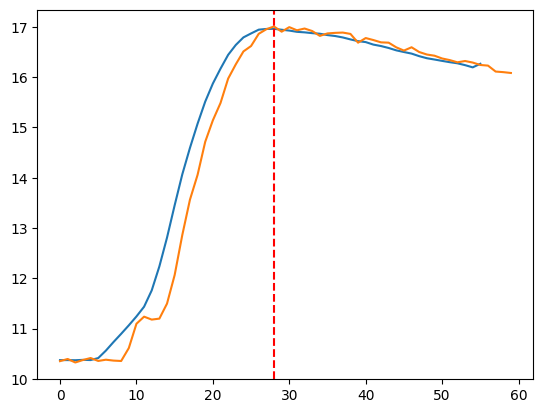

In [119]:
import matplotlib.pyplot as plt

peak_idx = np.argmax(cleaned_molecular)

plt.plot(cleaned_molecular)
plt.plot(molecular_feature_vals)

plt.axvline(x=peak_idx, color='r', linestyle='--', label='Peak')

In [ ]:
import matplotlib.pyplot as plt

startIx = 0; endIx = 100

stats_df = pd.DataFrame(columns=['mouse', 'day', 'feature', 'washout_rate',
                                        'min', 'max', 'mean', 'median', 'std', 'contrast'])

# Calculate washout rate for each curve
for idx, row in df.iterrows():  
    
    for featureIx in range(11, len(features)):
        feature = features[featureIx]
        bolus_vals = df.loc[idx, 'bolus-features'] 
        molecular_vals = df.loc[idx, 'molecular-features']
        
        bolus_feature_vals = []; molecular_feature_vals = []
        for j in range(startIx, min(endIx, len(bolus_vals))):
            try:
                bolus_feature_vals.append(bolus_vals[j][feature])
            except KeyError:
                bolus_feature_vals.append(bolus_feature_vals[-1])
            try:
                molecular_feature_vals.append(molecular_vals[j][feature])
            except KeyError:
                molecular_feature_vals.append(molecular_feature_vals[-1])
                
        
        # Remove outliers
        try:    
            smoothed_bolus_vals = smooth_curve(bolus_feature_vals)
        except ValueError:
            # print("Skipping", feature)
            continue
        smoothed_molecular_vals = smooth_curve(molecular_feature_vals)
        cleaned_bolus = remove_outliers(smoothed_bolus_vals)
        cleaned_molecular = remove_outliers(smoothed_molecular_vals)
        
        # Find the peak index
        if featureIx == 11:
            peak_idx = np.argmax(molecular_feature_vals)
        
        # Calculate slope of decay after peak (washout rate)
        # Using linear regression on log-transformed values
        time_points = np.arange(len(cleaned_molecular[peak_idx:]))
        molecular_log_values = cleaned_molecular[peak_idx:]
        bolus_log_values = cleaned_bolus[peak_idx:]
        
        # Fit line to log-transformed values
        try:
            molecular_slope, _ = np.polyfit(time_points, molecular_log_values, 1)
            bolus_slope, _ = np.polyfit(time_points, bolus_log_values, 1)
        except:
            print(idx)
            print("FEATURE", feature)
            print(molecular_log_values)
            print(molecular_vals)
            continue
        
        # Calculate additional statistics
        min_bolus = np.min(cleaned_bolus)
        max_bolus = np.max(cleaned_bolus)
        mean_bolus = np.mean(cleaned_bolus)
        median_bolus = np.median(cleaned_bolus)
        std_bolus = np.std(cleaned_bolus)
        
        min_molecular = np.min(cleaned_molecular)
        max_molecular = np.max(cleaned_molecular)
        mean_molecular = np.mean(cleaned_molecular)
        median_molecular = np.median(cleaned_molecular)
        std_molecular = np.std(cleaned_molecular)
        
        # Store results
        stats_df = pd.concat((stats_df, 
                                    pd.DataFrame({'mouse': [row['mouse']], 
                                                'day': [row['day']], 
                                                'feature': [feature],
                                                'washout_rate': [bolus_slope],
                                                'min': [min_bolus],
                                                'max': [max_bolus], 
                                                'mean': [mean_bolus],
                                                'median': [median_bolus],
                                                'std': [std_bolus],
                                                'contrast': ["Bolus"]})),
                                    ignore_index=True)
        
        stats_df = pd.concat((stats_df,
                                    pd.DataFrame({'mouse': [row['mouse']], 
                                                'day': [row['day']], 
                                                'feature': [feature],
                                                'washout_rate': [molecular_slope],
                                                'min': [min_molecular],
                                                'max': [max_molecular], 
                                                'mean': [mean_molecular],
                                                'median': [median_molecular],
                                                'std': [std_molecular],
                                                'contrast': ["Molecular"]})),
                                    ignore_index=True)

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_35749/433084428.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_df = pd.concat((stats_df,
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_35749/2160689499.py:38: RuntimeWarning: invalid value encountered in scalar divide
  z_score = abs((data[i] - np.mean(window)) / np.std(window))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_35749/2160689499.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = abs((data[i] - np.mean(window)) / np.std(window))


In [21]:
stats_df.tail()

,mouse,day,feature,washout_rate,min,max,mean,median,std,contrast
4923,m940,1,original_ngtdm_Complexity,1.939433e-04,0.015266,0.167621,0.140522,0.163133,0.048194,Molecular
4924,m940,1,original_ngtdm_Contrast,-8.073254e-05,0.003025,0.078322,0.010300,0.006844,0.015285,Bolus
4925,m940,1,original_ngtdm_Contrast,-1.742466e-05,0.000200,0.040289,0.032702,0.038425,0.013262,Molecular
4926,m940,1,original_ngtdm_Strength,3.263074e-06,0.000044,0.000834,0.000565,0.000562,0.000127,Bolus
4927,m940,1,original_ngtdm_Strength,-7.727066e-08,0.000062,0.000717,0.000130,0.000063,0.000162,Molecular


In [22]:
# Create a DataFrame for day differences
day_0_data = stats_df[stats_df['day'] == 0].copy()
day_1_data = stats_df[stats_df['day'] == 1].copy()

# Ensure we're comparing the same mice and features
comparison_cols = ['mouse', 'feature']
diff_df = day_1_data.merge(day_0_data, on=comparison_cols, suffixes=('_day1', '_day0'))

# Calculate differences for all numeric columns
numeric_cols = ['washout_rate', 'min', 'max', 'mean', 'median', 'std']

for col in numeric_cols:
    diff_df[f'{col}_diff'] = diff_df[f'{col}_day1'] - diff_df[f'{col}_day0']

# Keep only relevant columns
keep_cols = ['mouse', 'feature', 'contrast_day1'] + [f'{col}_diff' for col in numeric_cols]
diff_df = diff_df[keep_cols]

# Rename columns to be cleaner
diff_df = diff_df.rename(columns={'contrast_day1': 'contrast'})


In [23]:
diff_df.tail()

,mouse,feature,contrast,washout_rate_diff,min_diff,max_diff,mean_diff,median_diff,std_diff
4923,m940,original_ngtdm_Contrast,Molecular,1.731062e-05,0.000051,0.010302,0.009985,0.010525,0.002502
4924,m940,original_ngtdm_Strength,Bolus,3.835060e-06,-0.000038,-0.000563,0.000047,0.000103,-0.000077
4925,m940,original_ngtdm_Strength,Bolus,3.329555e-06,-0.000045,-0.000284,0.000361,0.000472,-0.000121
4926,m940,original_ngtdm_Strength,Molecular,4.947153e-07,-0.000020,-0.000679,-0.000388,-0.000396,-0.000043
4927,m940,original_ngtdm_Strength,Molecular,-1.078978e-08,-0.000027,-0.000401,-0.000074,-0.000027,-0.000086


In [ ]:
# Calculate range overlap for each feature
overlap_scores = []

cols = numeric_cols

for feature in stats_df['feature'].unique():
    feature_data = stats_df[stats_df['feature'] == feature]
    bolus_scans = feature_data[feature_data['contrast'] == "Bolus"]
    molecular_scans = feature_data[feature_data['contrast'] == "Molecular"]
    
    # Calculate number of overlapping points
    min_col = ""
    min_overlap = 1000000
    for col in cols:
        bolus_vals = bolus_scans[col].values
        molecular_vals = molecular_scans[col].values
        
        resp_min, resp_max = np.min(bolus_vals), np.max(bolus_vals)
        nonresp_min, nonresp_max = np.min(molecular_vals), np.max(molecular_vals)
        overlap_range = (max(resp_min, nonresp_min), min(resp_max, nonresp_max))
        
        if overlap_range[0] > overlap_range[1]:
            overlap_count = 0
        else:
            overlap_count = (
                np.sum((bolus_vals >= overlap_range[0]) &
                       (bolus_vals <= overlap_range[1])) +
                np.sum((molecular_vals >= overlap_range[0]) &
                       (molecular_vals <= overlap_range[1]))
            ) + 1
        if overlap_count < min_overlap:
            min_overlap = overlap_count
            min_col = col
            min_overlap_range = overlap_range
        if overlap_count == 0:
            print(f"Feature: {feature}, Column: {col}, Overlap Count: {overlap_count}")
            
            overlap_scores.append((feature, col, overlap_count, overlap_range))


Feature: diagnostics_Image-original_Mean, Column: min, Overlap Count: 0
Feature: original_firstorder_10Percentile, Column: min, Overlap Count: 0
Feature: original_firstorder_Mean, Column: min, Overlap Count: 0
Feature: original_firstorder_Median, Column: min, Overlap Count: 0
Feature: original_ngtdm_Coarseness, Column: max, Overlap Count: 0
Feature: original_ngtdm_Coarseness, Column: mean, Overlap Count: 0
Feature: original_ngtdm_Coarseness, Column: std, Overlap Count: 0


In [31]:
from scipy.optimize import curve_fit
from math import exp

def bolus_lognormal(x, auc, mu, sigma, t0):
   curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
   return np.nan_to_num(curve_fit)

In [123]:
import matplotlib.pyplot as plt

startIx = 0; endIx = 100

lognormal_df = pd.DataFrame(columns=['mouse', 'auc', 'mu', 'sigma', 't0', 'mtt', 'tp', 'pe', 'contrast'])

# Calculate washout rate for each curve
for idx, row in df.iterrows():  
    
    featureIx = 11
    feature = features[featureIx]
    bolus_vals = df.loc[idx, 'bolus-features'] 
    molecular_vals = df.loc[idx, 'molecular-features']
    
    bolus_feature_vals = []; molecular_feature_vals = []
    for j in range(startIx, min(endIx, len(bolus_vals))):
        try:
            bolus_feature_vals.append(bolus_vals[j][feature])
        except KeyError:
            bolus_feature_vals.append(bolus_feature_vals[-1])
        try:
            molecular_feature_vals.append(molecular_vals[j][feature])
        except KeyError:
            molecular_feature_vals.append(molecular_feature_vals[-1])
            
    
    # Remove outliers
    try:    
        smoothed_bolus_vals = smooth_curve(bolus_feature_vals)
    except ValueError:
        # print("Skipping", feature)
        continue
    smoothed_molecular_vals = smooth_curve(molecular_feature_vals)
    cleaned_bolus = remove_outliers(smoothed_bolus_vals)
    cleaned_molecular = remove_outliers(smoothed_molecular_vals)
    cleaned_bolus /= np.amax(cleaned_bolus)
    cleaned_molecular /= np.amax(cleaned_molecular)
    time_points = np.arange(len(cleaned_molecular))
    
    # Fit line to log-transformed values
    try:
        timeconst = 1
        popt, pcov = curve_fit(bolus_lognormal, time_points, cleaned_molecular, p0=(1.0,3.0,0.5,0.1),bounds=([0., 0., 0., -1.], [np.inf, np.inf, np.inf, 10.]),method='trf')#p0=(1.0,3.0,0.5,0.1) ,**kwargs
        popt, pcov = curve_fit(bolus_lognormal, time_points, cleaned_bolus, p0=(1.0,3.0,0.5,0.1),bounds=([0., 0., 0., -1.], [np.inf, np.inf, np.inf, 10.]),method='trf')#p0=(1.0,3.0,0.5,0.1) ,**kwargs
        auc = popt[0]; mu=popt[1]; sigma=popt[2]; t0=popt[3]; mtt=timeconst*np.exp(mu+sigma*sigma/2);
        tp = timeconst*exp(mu-sigma*sigma); wholecurve = bolus_lognormal(time_points, popt[0], popt[1], popt[2], popt[3]); pe = np.max(wholecurve);
        lognormal_df = pd.concat((lognormal_df, 
                                        pd.DataFrame({'mouse': [mouse],  
                                                    'auc': [auc],
                                                    'mu': [mu],
                                                    'sigma': [sigma],
                                                    't0': [t0],
                                                    'mtt': [mtt],
                                                    'tp': [tp],
                                                    'pe': [pe],
                                                    'contrast': ["Bolus"]})),
                                        ignore_index=True)

        popt, pcov = curve_fit(bolus_lognormal, time_points, cleaned_molecular, p0=(1.0,3.0,0.5,0.1),bounds=([0., 0., 0., -1.], [np.inf, np.inf, np.inf, 10.]),method='trf')#p0=(1.0,3.0,0.5,0.1) ,**kwargs
        auc = popt[0]; mu=popt[1]; sigma=popt[2]; t0=popt[3]; mtt=timeconst*np.exp(mu+sigma*sigma/2);
        tp = timeconst*exp(mu-sigma*sigma); wholecurve = bolus_lognormal(time_points, popt[0], popt[1], popt[2], popt[3]); pe = np.max(wholecurve);
        lognormal_df = pd.concat((lognormal_df, 
                                        pd.DataFrame({'mouse': [mouse],  
                                                    'auc': [auc],
                                                    'mu': [mu],
                                                    'sigma': [sigma],
                                                    't0': [t0],
                                                    'mtt': [mtt],
                                                    'tp': [tp],
                                                    'pe': [pe],
                                                    'contrast': ["Molecular"]})),
                                        ignore_index=True)
    except Exception as e:
        print(e)
        print("SKIPPING")
    

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_35749/2696483403.py:5: RuntimeWarning: invalid value encountered in log
  curve_fit=(auc/(2.5066*sigma*(x-t0)))*np.exp(-1*(((np.log(x-t0)-mu)**2)/(2*sigma*sigma)))
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_35749/1152090948.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lognormal_df = pd.concat((lognormal_df,


Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING
Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING
Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING
Optimal parameters not found: The maximum number of function evaluations is exceeded.
SKIPPING


In [124]:
lognormal_df.shape

(36, 9)

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_35749/3661447067.py:20: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(y_min, y_max)


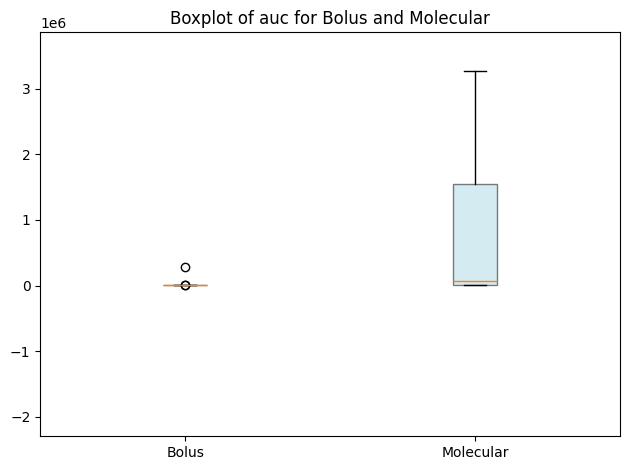

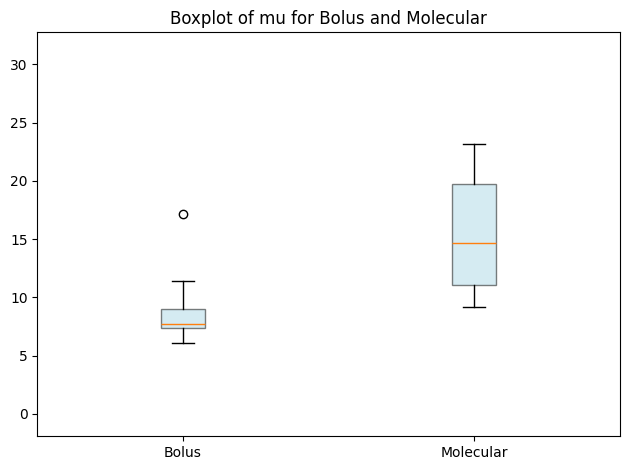

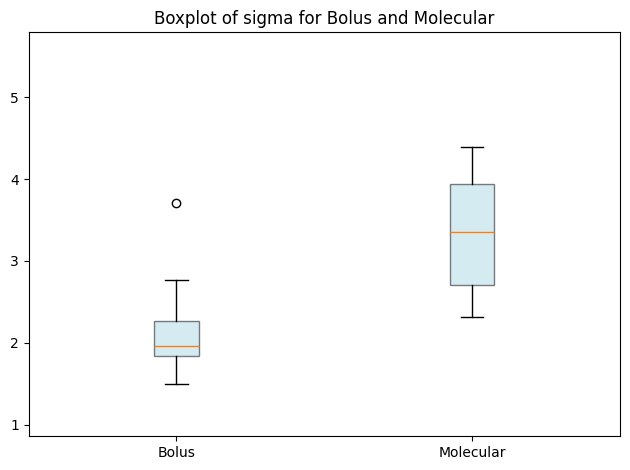

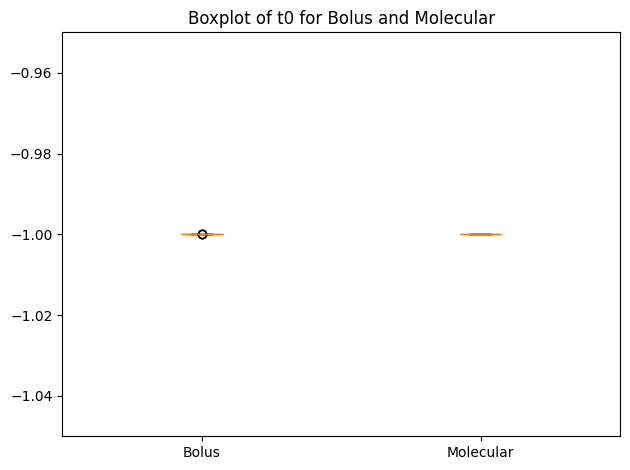

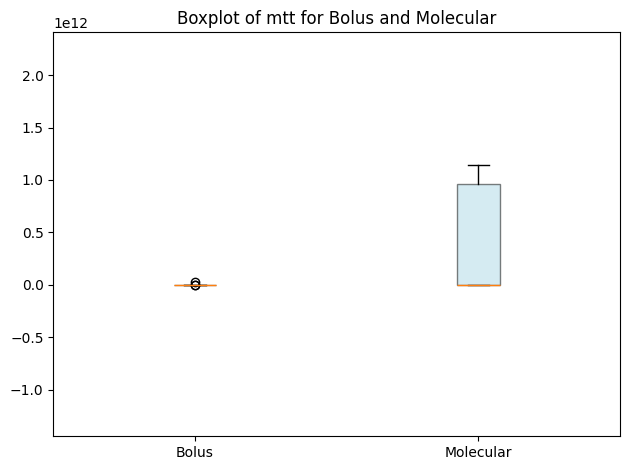

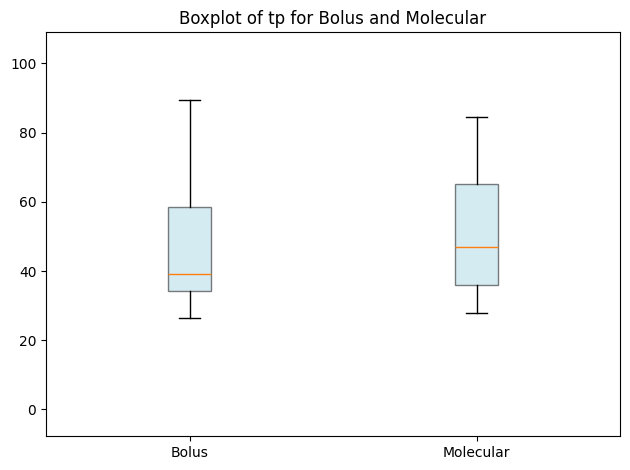

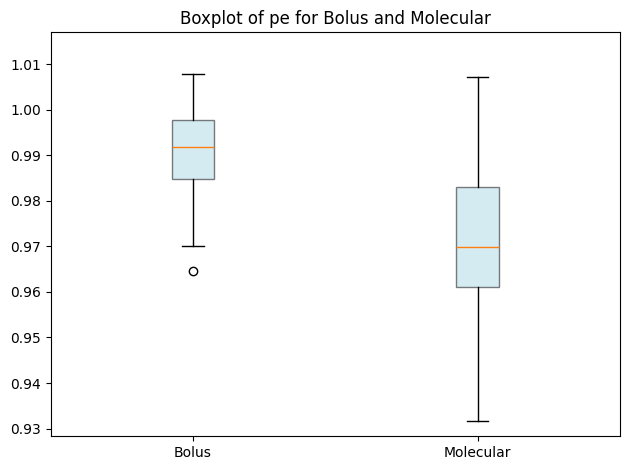

In [125]:
contrasts = lognormal_df['contrast'].values
for col in lognormal_df.columns:
    if col not in ['mouse', 'contrast']:
        bolus_vals = lognormal_df[lognormal_df['contrast'] == "Bolus"][col].values
        molecular_vals = lognormal_df[lognormal_df['contrast'] == "Molecular"][col].values
        
        fig, ax = plt.subplots()

        # Box plots for bolus
        bp1 = ax.boxplot([bolus_vals, molecular_vals], 
                        positions=[1, 2], patch_artist=True)
        for box in bp1['boxes']:
            box.set(facecolor='lightblue', alpha=0.5)
        ax.set_xticks([1, 2])
        ax.set_xticklabels(['Bolus', 'Molecular'])
        iqr_bolus = np.percentile(bolus_vals, 75) - np.percentile(bolus_vals, 25)
        iqr_molecular = np.percentile(molecular_vals, 75) - np.percentile(molecular_vals, 25)
        y_min = min(np.percentile(bolus_vals, 25) - 1.5 * iqr_bolus, np.percentile(molecular_vals, 25) - 1.5 * iqr_molecular)
        y_max = max(np.percentile(bolus_vals, 75) + 1.5 * iqr_bolus, np.percentile(molecular_vals, 75) + 1.5 * iqr_molecular)
        ax.set_ylim(y_min, y_max)
        
        ax.set_title(f'Boxplot of {col} for Bolus and Molecular')
        plt.tight_layout()


In [ ]:
# Calculate range overlap for each feature
overlap_scores = []

cols = numeric_cols

for feature in lognormal_df['feature'].unique():
    feature_data = stats_df[stats_df['feature'] == feature]
    bolus_scans = feature_data[feature_data['contrast'] == "Bolus"]
    molecular_scans = feature_data[feature_data['contrast'] == "Molecular"]
    
    # Calculate number of overlapping points
    min_col = ""
    min_overlap = 1000000
    for col in cols:
        bolus_vals = bolus_scans[col].values
        molecular_vals = molecular_scans[col].values
        
        resp_min, resp_max = np.min(bolus_vals), np.max(bolus_vals)
        nonresp_min, nonresp_max = np.min(molecular_vals), np.max(molecular_vals)
        overlap_range = (max(resp_min, nonresp_min), min(resp_max, nonresp_max))
        
        if overlap_range[0] > overlap_range[1]:
            overlap_count = 0
        else:
            overlap_count = (
                np.sum((bolus_vals >= overlap_range[0]) &
                       (bolus_vals <= overlap_range[1])) +
                np.sum((molecular_vals >= overlap_range[0]) &
                       (molecular_vals <= overlap_range[1]))
            ) + 1
        if overlap_count < min_overlap:
            min_overlap = overlap_count
            min_col = col
            min_overlap_range = overlap_range
        if overlap_count == 0:
            print(f"Feature: {feature}, Column: {col}, Overlap Count: {overlap_count}")
            
            overlap_scores.append((feature, col, overlap_count, overlap_range))


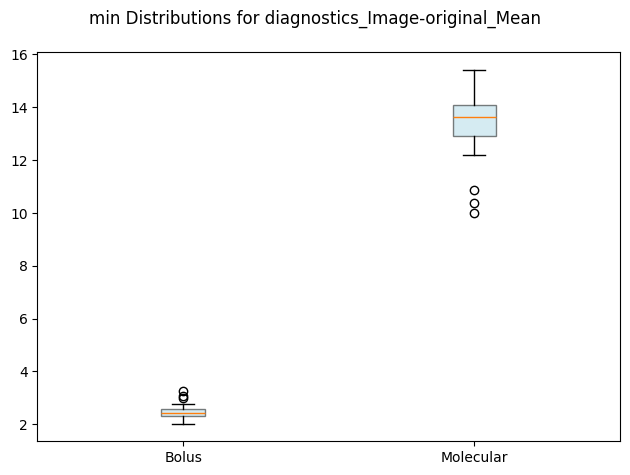

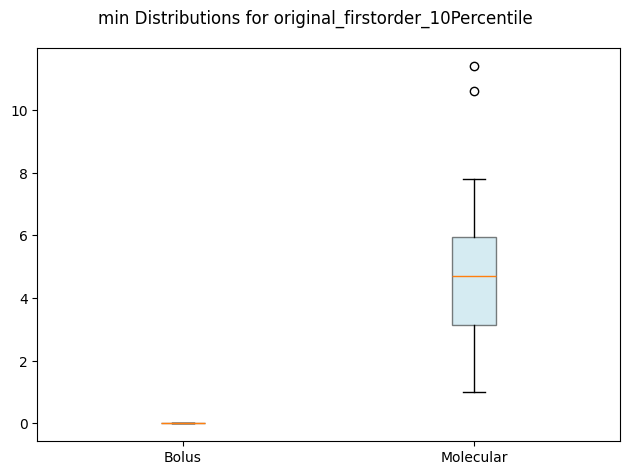

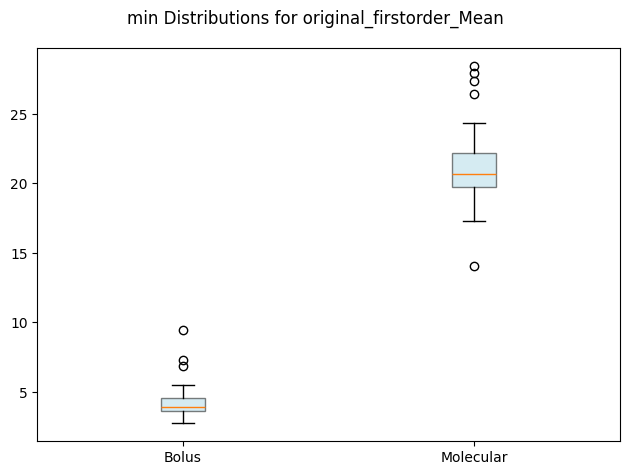

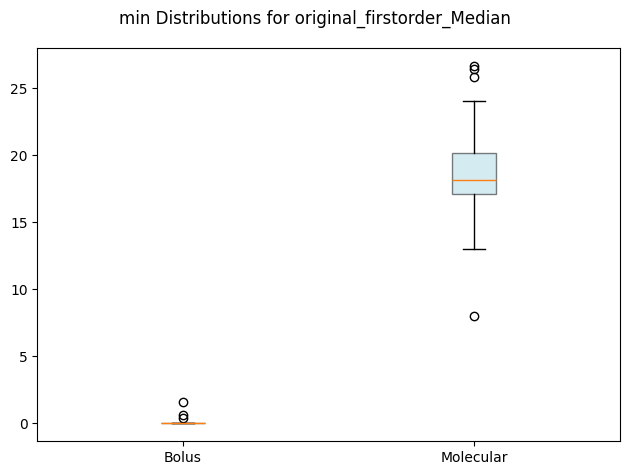

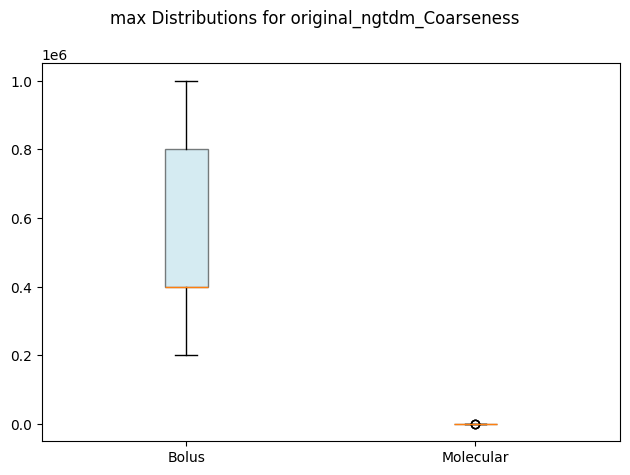

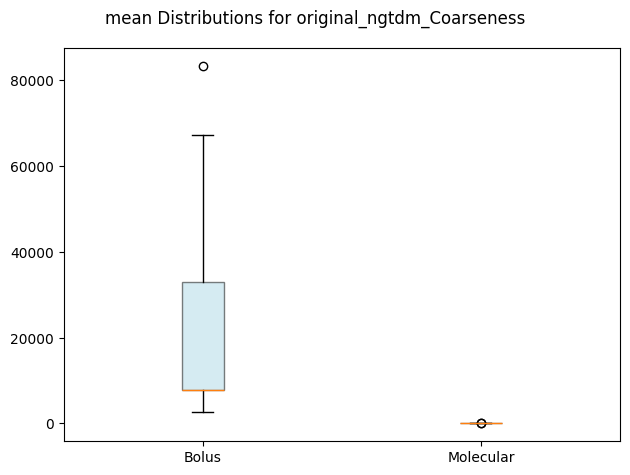

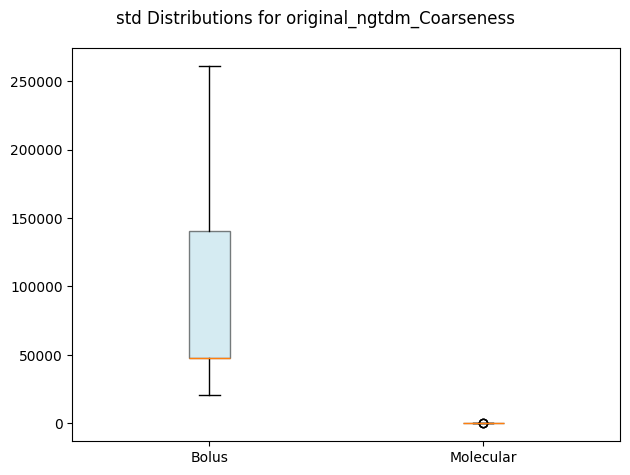

In [74]:
# Find feature with minimum overlap
for feature in overlap_scores:
    if feature[2] != 0:
        continue
        
    # Plot the distributions for the best feature
    feature_data = stats_df[stats_df['feature'] == feature[0]]
    bolus_scans = feature_data[feature_data['contrast'] == "Bolus"]
    molecular_scans = feature_data[feature_data['contrast'] == "Molecular"]

    fig, ax = plt.subplots()

    # Box plots for bolus
    bp1 = ax.boxplot([bolus_scans[feature[1]], molecular_scans[feature[1]]], 
                    positions=[1, 2], patch_artist=True)
    for box in bp1['boxes']:
        box.set(facecolor='lightblue', alpha=0.5)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Bolus', 'Molecular'])

    plt.suptitle(f'{feature[1]} Distributions for {feature[0]}')
    plt.tight_layout()


In [135]:
feature_data = stats_df[stats_df['feature'] == 'original_ngtdm_Coarseness']
bolus_scans = feature_data[feature_data['contrast'] == "Bolus"]
molecular_scans = feature_data[feature_data['contrast'] == "Molecular"]

In [136]:
# bolus_scans = lognormal_df[lognormal_df['contrast'] == "Bolus"]
# molecular_scans = lognormal_df[lognormal_df['contrast'] == "Molecular"]

In [139]:
b_vals = bolus_scans['std'].values
m_vals = molecular_scans['std'].values

In [140]:
m_vals

array([2.29049052e-05, 2.29905935e-05, 1.09363262e-04, 4.74242150e-04,
       2.40994152e-04, 1.89445540e-04, 1.25588883e-04, 1.89768478e-04,
       4.31693086e-04, 1.12629175e-02, 1.96287678e-04, 6.59706924e-04,
       3.47963801e-04, 4.67162311e-04, 9.95097115e-04, 6.02275588e-04,
       1.79450795e-03, 2.58350097e-03, 6.24673801e-04, 1.16010274e-03,
       2.47577067e-04, 1.61520258e-04])

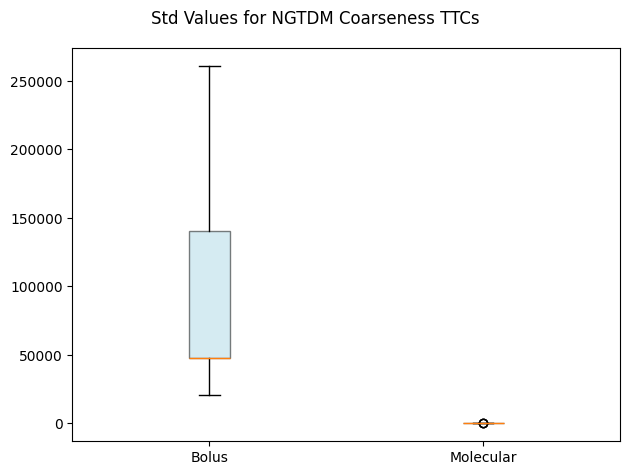

In [142]:

fig, ax = plt.subplots()

# Box plots for bolus
bp1 = ax.boxplot([b_vals, m_vals], 
                positions=[1, 2], patch_artist=True)
for box in bp1['boxes']:
    box.set(facecolor='lightblue', alpha=0.5)
ax.set_xticks([1, 2])
ax.set_xticklabels(['Bolus', 'Molecular'])

plt.suptitle(f'Std Values for NGTDM Coarseness TTCs')
plt.tight_layout()


In [143]:
min(b_vals)

20878.856982766163

In [146]:
from scipy.stats import norm

# Calculate the mean and standard deviation of m_vals
mean_m_vals = np.mean(m_vals)
std_m_vals = np.std(m_vals)

# Calculate the z-score for min(b_vals)
z_score = (min(b_vals) - mean_m_vals) / std_m_vals

# Calculate the probability using the cumulative distribution function (CDF)
probability = 1 - norm.cdf(z_score)

print(f"Probability that min(b_vals) belongs to the m_vals distribution: {probability:.4f}")

Probability that min(b_vals) belongs to the m_vals distribution: 0.0000


In [145]:
z_score

9036345.461912567

In [130]:
from scipy.stats import wilcoxon

stat, p = wilcoxon(b_vals, m_vals)
print(f"Wilcoxon test statistic = {stat}, p-value = {p}")

Wilcoxon test statistic = 24.0, p-value = 0.0055999755859375


In [131]:
from scipy.stats import shapiro
import numpy as np

# Your paired samples
bolus = np.array([b_vals])
molecular = np.array([m_vals])

# Calculate paired differences
differences = bolus - molecular

# Shapiro-Wilk test for normality
stat, p = shapiro(differences)
print(f"Shapiro-Wilk test statistic: {stat:.4f}, p-value: {p:.4f}")

if p > 0.05:
    print("✅ Differences appear normally distributed (fail to reject H0)")
else:
    print("❌ Differences do NOT appear normally distributed (reject H0)")

Shapiro-Wilk test statistic: 0.9345, p-value: 0.2325
✅ Differences appear normally distributed (fail to reject H0)


In [132]:
from scipy.stats import ttest_rel
import numpy as np

# Example: Replace these with your actual paired data
bolus = np.array(b_vals)
molecular = np.array(m_vals)

# Perform paired t-test
t_stat, p_value = ttest_rel(bolus, molecular)

print(f"Paired t-test statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Optional interpretation
alpha = 0.05
if p_value < alpha:
    print("Result: Significant difference between Bolus and Molecular (reject null hypothesis)")
else:
    print("Result: No significant difference (fail to reject null hypothesis)")

Paired t-test statistic: 3.4560
P-value: 0.0030
Result: Significant difference between Bolus and Molecular (reject null hypothesis)
